In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data_0 = pandas.read_csv('Data/hits.csv', index_col=0)

data_1 = data_0.copy()
data_1['Wy1'] = data_0['Wy1'].values + data_0.dist2Wire.values
data_1['Wy2'] = data_0['Wy2'].values + data_0.dist2Wire.values
data_2 = data_0.copy()
data_2['Wy1'] = data_0['Wy1'].values - data_0.dist2Wire.values
data_2['Wy2'] = data_0['Wy2'].values - data_0.dist2Wire.values
data = pandas.concat([data_1, data_2], axis=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,0.042245,-250.000000,250.000000,0.910845,0.910845,2581.1500,2581.1500,2581.1500,0,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,0.478996,-248.589486,249.507863,27.516483,-16.061389,3542.3793,3542.3793,3542.3793,0,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,0.310706,-248.587499,249.509850,-26.749494,16.828378,2592.3793,2592.3793,2592.3793,0,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,0.117904,-248.894287,249.203062,-23.435691,20.142180,2592.3793,2592.3793,2592.3793,1,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,0.437575,-250.000000,250.000000,0.426175,0.426175,2782.2500,2782.2500,2782.2500,0,0


# Train / Test Split

In [4]:
from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=10, random_state=42)
event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)

5


# Tracks Reconstruction

In [5]:
from baseline import SimpleTemplateMatching
from regressor import MultiLinearRegression
from reconstruction import TracksReconstruction2D
from combination import Combinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [6]:
event = data[data.EventID == 10]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]
#event12 = event12[event12.Label.values == 1]

x = event12.Wz1.values
y = event12.Wy1.values

labels = []
tracks_params = []

In [7]:
%%time
mlr = MultiLinearRegression(n_tracks=2, 
                            n_neighbors=10, 
                            min_samples=3, 
                            subsample=1., 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
mlr.fit(x, y)

labels = mlr.labels_
tracks_params = mlr.tracks_params_

CPU times: user 4.76 s, sys: 47.9 ms, total: 4.81 s
Wall time: 4.82 s


In [8]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [9]:
tracks_params

array([[ -1.37725263e-02,  -5.99408360e+01],
       [  1.95832153e-02,  -5.01332785e+00]])

In [10]:
labels

array([-1.,  0.,  0., -1., -1.,  0., -1., -1.,  1.,  1.,  0.,  1., -1.,
       -1., -1., -1.,  0., -1.,  1.,  1., -1., -1.,  0.,  0., -1.,  1.,
        0., -1., -1., -1., -1.,  1.,  0.,  0.,  1., -1.,  1., -1.])

In [11]:
event12.Label.values

array([ 0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.])

### Train Classifiers

In [12]:
from regressor import DataCollection


model_y = MultiLinearRegression(n_tracks=2, 
                            n_neighbors=5, 
                            min_samples=3, 
                            subsample=0.5, 
                            x_unique=True, 
                            track_classifier=None, 
                            hit_classifier=None)
model_stereo = MultiLinearRegression(n_tracks=1, 
                                n_neighbors=5, 
                                min_samples=3, 
                                subsample=0.5, 
                                x_unique=True, 
                                track_classifier=None, 
                                hit_classifier=None)

In [13]:
%%time

dc = DataCollection(model_y, model_stereo)

track_clf_data_y_train, \
hit_clf_data_y_train, \
track_clf_data_stereo_train, \
hit_clf_data_stereo_train = dc.clf_train_data(data, event_ids_train)

CPU times: user 1min 11s, sys: 508 ms, total: 1min 12s
Wall time: 1min 13s


In [14]:
%%time

dc = DataCollection(model_y, model_stereo)

track_clf_data_y_valid, \
hit_clf_data_y_valid, \
track_clf_data_stereo_valid, \
hit_clf_data_stereo_valid = dc.clf_train_data(data, event_ids_valid)

CPU times: user 55.3 s, sys: 256 ms, total: 55.6 s
Wall time: 56.3 s


### Train track classifier for y-views

In [18]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
clf_track_y = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.01, nthreads=1, 
                             subsample=0.7, max_depth=8)

X_data_train = track_clf_data_y_train[track_clf_data_y_train.columns[:-1]].values
y_data_train = track_clf_data_y_train['label'].values

X_data_valid = track_clf_data_y_valid[track_clf_data_y_valid.columns[:-1]].values
y_data_valid = track_clf_data_y_valid['label'].values

%time clf_track_y.fit(X_data_train, y_data_train)

y_proba_valid = clf_track_y.predict_proba(X_data_valid)[:, 1]

CPU times: user 4.42 s, sys: 63.7 ms, total: 4.48 s
Wall time: 4.66 s


0.948173754412


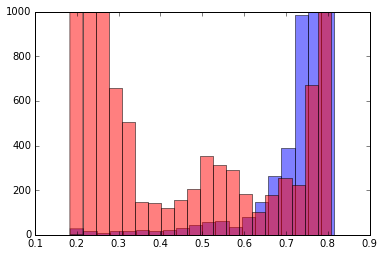

In [19]:
from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data_valid, y_proba_valid)

plt.hist(y_proba_valid[y_data_valid==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba_valid[y_data_valid==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,1000)
plt.show()

### Train hit classifier for y-views

In [20]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
clf_hit_y = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.01, nthreads=1, 
                             subsample=0.7, max_depth=8)

X_data_train = hit_clf_data_y_train[hit_clf_data_y_train.columns[:-1]].values
y_data_train = hit_clf_data_y_train['label'].values

X_data_valid = hit_clf_data_y_valid[hit_clf_data_y_valid.columns[:-1]].values
y_data_valid = hit_clf_data_y_valid['label'].values

%time clf_hit_y.fit(X_data_train, y_data_train)

y_proba_valid = clf_hit_y.predict_proba(X_data_valid)[:, 1]

CPU times: user 19.9 ms, sys: 2.04 ms, total: 21.9 ms
Wall time: 19.9 ms


0.917650860803


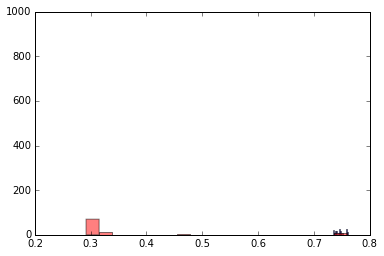

In [21]:
from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data_valid, y_proba_valid)

plt.hist(y_proba_valid[y_data_valid==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba_valid[y_data_valid==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,1000)
plt.show()

### Train track classifier for stereo-views

In [22]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
clf_track_stereo = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.01, nthreads=1, 
                             subsample=0.7, max_depth=8)

X_data_train = track_clf_data_stereo_train[track_clf_data_stereo_train.columns[:-1]].values
y_data_train = track_clf_data_stereo_train['label'].values

X_data_valid = track_clf_data_stereo_valid[track_clf_data_stereo_valid.columns[:-1]].values
y_data_valid = track_clf_data_stereo_valid['label'].values

%time clf_track_stereo.fit(X_data_train, y_data_train)

y_proba_valid = clf_track_stereo.predict_proba(X_data_valid)[:, 1]

CPU times: user 9.08 s, sys: 101 ms, total: 9.18 s
Wall time: 9.44 s


0.870154248594


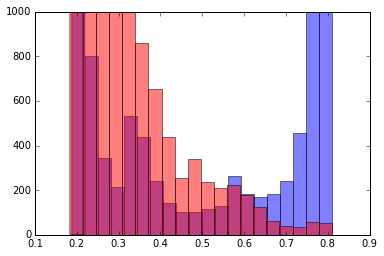

In [23]:
from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data_valid, y_proba_valid)

plt.hist(y_proba_valid[y_data_valid==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba_valid[y_data_valid==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,1000)
plt.show()

### Train hit classifier for stereo-views

In [24]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
clf_hit_stereo = XGBoostClassifier(n_estimators=100, colsample=0.7, eta=0.01, nthreads=1, 
                             subsample=0.7, max_depth=8)

X_data_train = hit_clf_data_stereo_train[hit_clf_data_stereo_train.columns[:-1]].values
y_data_train = hit_clf_data_stereo_train['label'].values

X_data_valid = hit_clf_data_stereo_valid[hit_clf_data_stereo_valid.columns[:-1]].values
y_data_valid = hit_clf_data_stereo_valid['label'].values

%time clf_hit_stereo.fit(X_data_train, y_data_train)

y_proba_valid = clf_hit_stereo.predict_proba(X_data_valid)[:, 1]

CPU times: user 23.4 ms, sys: 234 µs, total: 23.6 ms
Wall time: 24 ms


0.993016975309


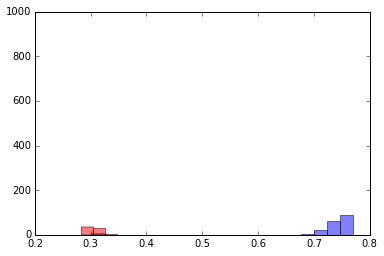

In [25]:
from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data_valid, y_proba_valid)

plt.hist(y_proba_valid[y_data_valid==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba_valid[y_data_valid==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,1000)
plt.show()

### Tracks Reconstruction

In [27]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = MultiLinearRegression(n_tracks=2, 
                            n_neighbors=5, 
                            min_samples=3, 
                            subsample=0.5, 
                            x_unique=True, 
                            track_classifier=clf_track_y, 
                            hit_classifier=clf_hit_y)
    stm_stereo = MultiLinearRegression(n_tracks=1, 
                            n_neighbors=5, 
                            min_samples=3, 
                            subsample=0.5, 
                            x_unique=True, 
                            track_classifier=clf_track_stereo, 
                            hit_classifier=clf_hit_stereo)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids[:3])
    tracks = merge_dicts(results)

# results = []
# for event_id in event_ids[:10]:
#     one_result = tracks_reconstruction(event_id)
#     results.append(one_result)
# tracks = merge_dicts(results)

CPU times: user 29.6 ms, sys: 21.8 ms, total: 51.4 ms
Wall time: 18.2 s


In [28]:
#tracks_reconstruction(2)

In [29]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_y_ == 1)*1, 
                                                     (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_y_ == 1)*1, 
                                                     (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()


CPU times: user 105 ms, sys: 5.55 ms, total: 110 ms
Wall time: 110 ms


In [30]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

3

In [31]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,2,1.000000,1,0,0
1,10,1.000000,1,0,0
2,7,0.888889,1,0,0


In [32]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,2,1,1,0,0
1,10,1,1,0,0
2,7,1,1,0,0


# Quality

# Stations 1&2

### Y-views

In [22]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.994956
RecoEff         0.997761
GhostRate       0.000000
CloneRate       0.002985
dtype: float64

### Stereo-views

In [23]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.989053
RecoEff         0.991791
GhostRate       0.001493
CloneRate       0.006716
dtype: float64

### Stations 1&2

In [24]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.988172
RecoEff         0.997015
GhostRate       0.000000
CloneRate       0.002985
dtype: float64

### Track efficiency

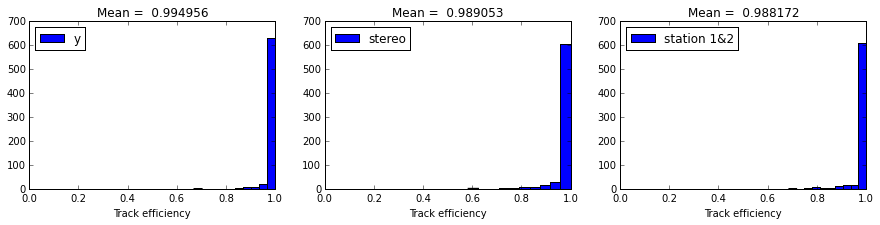

In [25]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

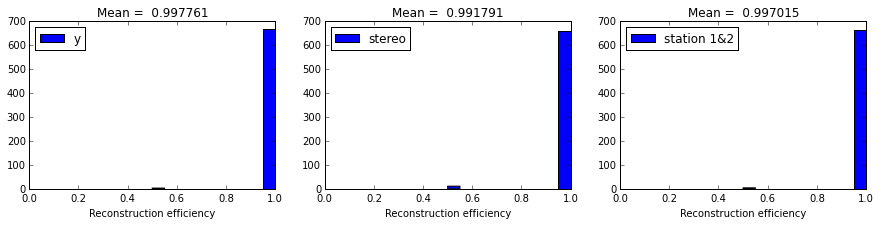

In [26]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [27]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.990930
RecoEff         0.997761
GhostRate       0.000746
CloneRate       0.011940
dtype: float64

### Stereo-views

In [28]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.984174
RecoEff         0.995522
GhostRate       0.001493
CloneRate       0.002985
dtype: float64

### Station 3&4

In [29]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.983207
RecoEff         0.995522
GhostRate       0.000746
CloneRate       0.003731
dtype: float64

### Tracks efficiency

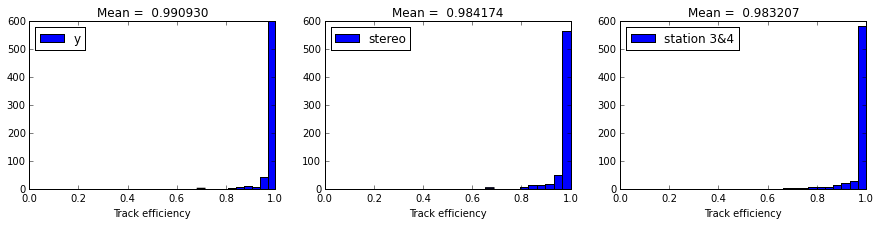

In [30]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

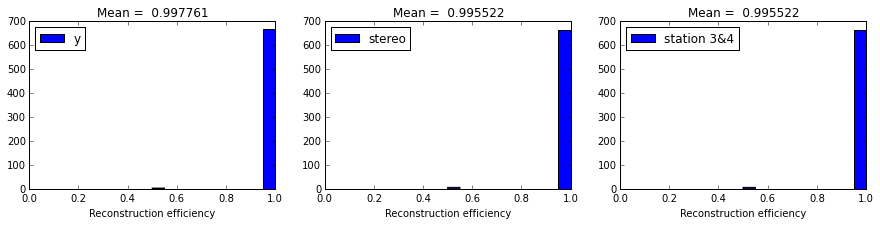

In [31]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [32]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.976866
GhostRate       0.002239
CloneRate       0.000746
NCombined       1.955224
dtype: float64

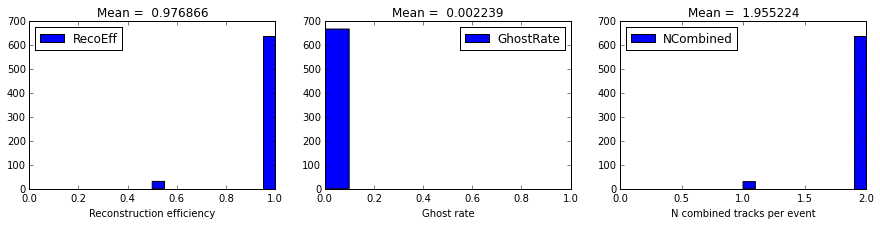

In [33]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

95.3731343284


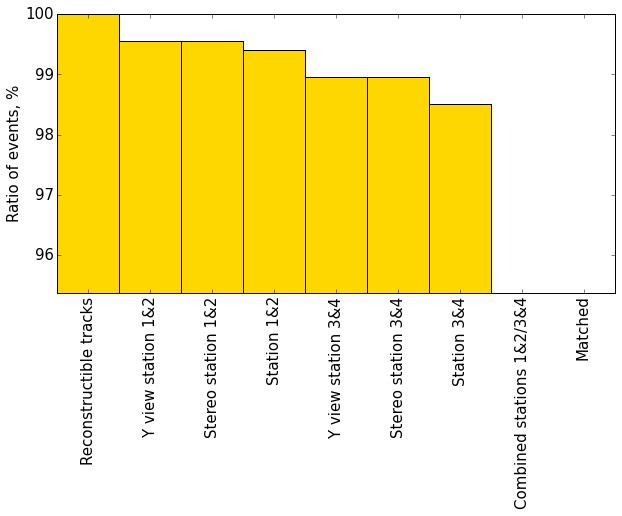

In [34]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [35]:
bar_values

array([ 100.        ,   99.55223881,   99.55223881,   99.40298507,
         98.95522388,   98.95522388,   98.50746269,   95.37313433,
         95.37313433])

# Momentum

In [36]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

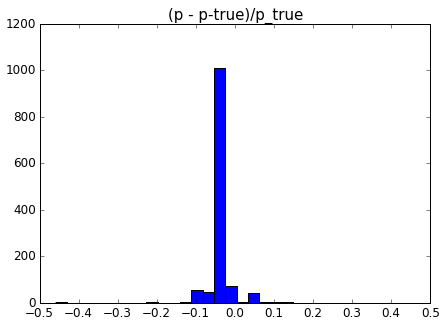

In [37]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [38]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

3